<a href="https://colab.research.google.com/github/foodbanana/AI_ME_Course_2025/blob/main/AIME_20251112.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Softmax layer with loss calculation                     # Softmax + 교차엔트로피 손실을 묶은 최종 계층

class SoftmaxWithLoss:                                    # 분류기의 마지막 계층(순전파: 손실, 역전파: 기울기)
    def __init__(self):                                   # 생성자
        self.loss = None                                  # 손실 스칼라 저장용
        self.pred = None                                  # 소프트맥스 예측 확률(배치×클래스)
        self.y = None                                     # 원-핫 정답 레이블(배치×클래스)

    def forward(self, x, y):                              # 순전파: 로짓 x와 정답 y로 손실 계산
        self.y = y                                        # 역전파 때 사용할 정답 저장
        self.pred = Softmax(x)                            # 소프트맥스로 확률 분포 계산
        self.loss = CE(self.pred, self.y)                 # 교차엔트로피 손실 계산(현재는 합계 형태)
        return self.loss                                  # 손실 반환

    def backward(self, dout=1):                           # 역전파: 상류 미분(보통 1)을 입력
        batch_size = self.y.shape[0]                      # 배치 크기(평균 기울기 계산용)
        dx = (self.pred - self.y) / batch_size            # dL/dx = (pred - y)/N (Softmax+CE의 표준 결과)
        return dx                                         # 이전 계층으로 전달할 기울기



In [2]:
from collections import OrderedDict                  # 계층을 순서대로 보관(순전파/역전파 순회에 필요)
import numpy as np                                   # 수치 연산(난수, 행렬곱, 합계 등)

# 이 코드가 실행되기 위해서는                             # 의존성 안내(미리 정의되어야 하는 구성요소)
# Affine, ReLU, SoftmaxWithLoss 클래스와                 # 각 계층 클래스
# Softmax, CE 함수가 미리 정의되어 있어야 합니다.        # 활성화/손실 함수

class network:                                        # 2층 신경망 정의(입력-은닉-출력)
    def __init__(self, input_size, hidden_size, output_size, weight_init=0.01):
        """
        신경망의 파라미터와 계층을 초기화합니다.            # 가중치/편향 초기화, 계층 구성
        """
        # 가중치와 편향 파라미터 초기화
        self.params = {}                               # 파라미터 저장용 딕셔너리
        self.params['W1'] = weight_init * np.random.randn(input_size, hidden_size)   # 1층 가중치
        self.params['b1'] = np.zeros(hidden_size)      # 1층 편향
        self.params['W2'] = weight_init * np.random.randn(hidden_size, output_size)  # 2층 가중치
        self.params['b2'] = np.zeros(output_size)      # 2층 편향

        # 계층 생성
        self.layers = OrderedDict()                    # 순서를 유지하는 계층 컨테이너
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])  # 입력→은닉 선형
        self.layers['ReLU1']   = ReLU()                # 비선형 활성화
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])  # 은닉→출력 선형

        self.lastlayer = SoftmaxWithLoss()             # 최종 손실 계층(Softmax + CE)

    def predict(self, x):
        """
        입력 데이터 x에 대한 예측을 수행합니다.              # 순전파로 로짓 출력 반환
        """
        # 순전파
        for layer in self.layers.values():             # 등록된 계층 순서대로
            x = layer.forward(x)                       # 각 계층의 forward 통과
        return x                                       # 마지막 Affine 출력(로짓)

    def loss(self, x, y):
        """
        손실 함수 값을 계산합니다.                         # SoftmaxWithLoss로 손실 산출
        x: 입력 데이터, y: 정답 레이블
        """
        pred = self.predict(x)                         # 로짓 얻기
        return self.lastlayer.forward(pred, y)         # 손실 계산 및 반환

    def gradients(self, x, y):
        """
        역전파를 통해 기울기를 계산합니다.                 # 모든 파라미터의 gradient 산출
        """
        # 순전파를 통해 각 계층에 중간 데이터 저장
        self.loss(x, y)                                # forward 수행(캐시 갱신)

        # 역전파 시작
        dout = 1                                       # 손실에 대한 미분(dL/dL)
        dout = self.lastlayer.backward(dout)           # SoftmaxWithLoss 역전파로 dL/d(logit)

        # 계층 순서를 뒤집어서 역전파 수행
        layers = list(self.layers.values())            # 계층 리스트화
        layers.reverse()                               # 역순(출력→입력 방향)
        for layer in layers:
            dout = layer.backward(dout)                # 각 계층 backward 호출

        # 각 파라미터의 기울기를 grads 딕셔너리에 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW        # 1층 가중치 기울기
        grads['b1'] = self.layers['Affine1'].db        # 1층 편향 기울기
        grads['W2'] = self.layers['Affine2'].dW        # 2층 가중치 기울기
        grads['b2'] = self.layers['Affine2'].db        # 2층 편향 기울기

        return grads                                   # 경사하강법 업데이트에 사용





In [3]:
# Affine layer with backward process                          # 완전연결(선형) 계층과 그 역전파

class Affine:                                                 # Affine(=Dense/Linear) 계층 정의
    def __init__(self, W, b):                                 # 생성자: 가중치와 편향을 외부에서 주입
        self.W = W                                            # 가중치 행렬 (in_features × out_features)
        self.b = b                                            # 편향 벡터 (out_features,)
        self.x = None                                         # 순전파 시 입력을 캐시(역전파에서 사용)
        self.dW = None                                        # 가중치에 대한 기울기(역전파 결과 저장)
        self.db = None                                        # 편향에 대한 기울기(역전파 결과 저장)

    def forward(self, x):                                     # 순전파: y = xW + b
        self.x = x                                            # 역전파용으로 입력 보관 (batch × in_features)
        out = np.dot(x, self.W) + self.b                      # 행렬곱과 브로드캐스트로 선형변환 수행
        return out                                            # 다음 계층으로 출력 전달 (batch × out_features)

    def backward(self, dout):                                  # 역전파: 상류 미분 dout을 받아 하류로 전달
        dx = np.dot(dout, self.W.T)                           # 입력 x에 대한 기울기: dL/dx = dout · W^T
        self.dW = np.dot(self.x.T, dout)                      # 가중치 기울기: dL/dW = x^T · dout
        self.db = np.sum(dout, axis=0)                        # 편향 기울기: 배치 축으로 합산(브로드캐스트 역미분)
        return dx                                             # 이전 계층으로 dL/dx 반환



In [4]:
# ReLU with backward process                          # ReLU 계층(순전파/역전파) 구현

class ReLU:                                            # ReLU 클래스 정의
    def __init__(self):                                # 생성자
        self.mask = None                               # 순전파에서 x<=0인 위치를 기억할 불리언 마스크

    def forward(self, x):                              # 순전파: 입력 x에 ReLU 적용
        self.mask = (x <= 0)                           # x가 0 이하인 위치(True/False) 저장
        out = x.copy()                                 # 입력 보존을 위해 복사본 생성
        out[self.mask] = 0                             # 0 이하 위치의 값을 0으로 설정
        return out                                     # ReLU 적용 결과 반환

    def backward(self, dout):                          # 역전파: 상류 미분 dout을 받아 하류로 전달
        dout[self.mask] = 0                            # 순전파 때 0 이하였던 위치의 기울기는 0
        dx = dout                                      # 나머지는 그대로 통과(∂ReLU/∂x = 1)
        return dx                                      # 이전 계층으로 전달할 기울기 반환



In [5]:
# Implemented before

def CE(pred, y):                              # pred: 소프트맥스 확률(배치×클래스), y: 원-핫 정답(배치×클래스)
    delta = 1e-7                              # log(0) 방지용 작은 상수(수치 안정성)
    return -np.sum(y * np.log(pred + delta))  # 교차 엔트로피 손실(배치 전체 합; 평균이 아님)

def Softmax(x):                               # x: 로짓(배치×클래스)
    M = np.max(x, axis=1, keepdims=True)      # 각 샘플별 최댓값(오버플로우 방지용 기준)
    z = x - M                                  # 안정화된 로짓(최댓값을 0으로 이동)
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)  # 행(샘플)별 확률 분포로 정규화

x = np.array([[0,0],                          # 입력 샘플 1: (0, 0)
              [0,1],                          # 입력 샘플 2: (0, 1)
              [1,0],                          # 입력 샘플 3: (1, 0)
              [1,1]])                         # 입력 샘플 4: (1, 1)

y = np.array([[1,0],                          # 레이블 1: 클래스 0 → [1, 0]
              [0,1],                          # 레이블 2: 클래스 1 → [0, 1]
              [0,1],                          # 레이블 3: 클래스 1 → [0, 1]
              [1,0]])                         # 레이블 4: 클래스 0 → [1, 0]



In [6]:
# Initialize network # 신경망 인스턴스 생성 및 초기 예측 확인

net = network(input_size=2, hidden_size=4, output_size=2) # 입력 2, 은닉 4, 출력 2인 2층 네트워크 생성




In [7]:
import numpy as np                      # 수치 계산 라이브러리(배열/행렬 연산, 난수, 브로드캐스팅 등)
import matplotlib.pyplot as plt         # 시각화 인터페이스(학습 곡선 plot, title, show 등에 사용)
from collections import OrderedDict     # 삽입 순서를 유지하는 dict(레이어 순서 보존, 순전파/역전파 순회에 사용)

In [8]:
import numpy as np
from collections import OrderedDict
import matplotlib.pylab as plt


In [9]:
# Hyperparameter
learning_rate = 1e-2
iters_num = 100000

# Training
train_loss_history = []

for i in range(iters_num):
    grads = net.gradients(x, y)

    for key in net.params.keys():
        net.params[key] -= grads[key] * learning_rate

    loss = net.loss(x, y)
    train_loss_history.append(loss)


In [10]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]


In [11]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]


In [12]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

In [13]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)


In [14]:
def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0 * y

x = np.arange(-10, 10, 0.1)
y = np.arange(-5, 5, 0.1)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)


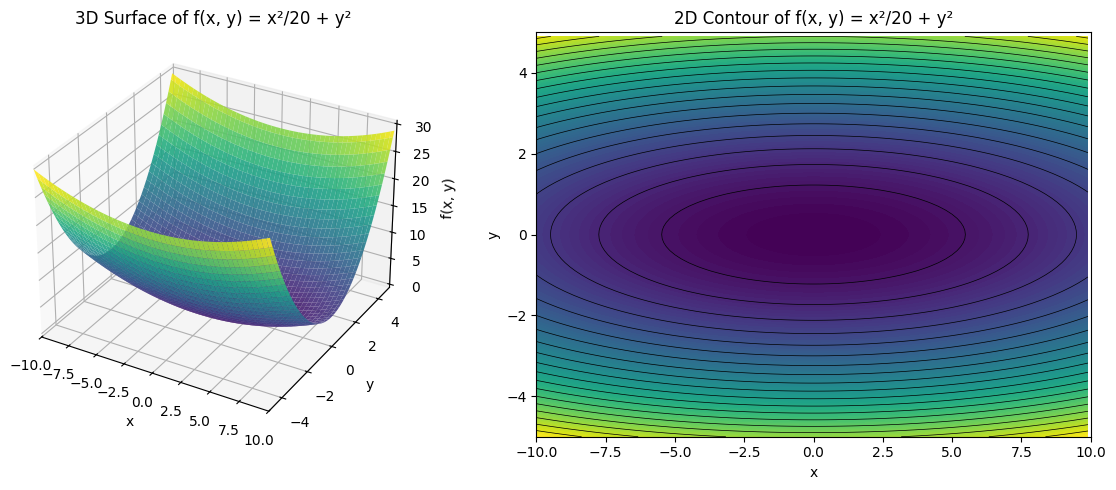

In [15]:
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.9, edgecolor='none')
ax1.set_title("3D Surface of f(x, y) = x²/20 + y²")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("f(x, y)")
ax1.set_xlim(-10, 10)
ax1.set_ylim(-5, 5)

ax2 = fig.add_subplot(1, 2, 2)
contour = ax2.contourf(X, Y, Z, levels=100, cmap='viridis')
ax2.contour(X, Y, Z, levels=20, colors='k', linewidths=0.5)
ax2.set_title("2D Contour of f(x, y) = x²/20 + y²")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_xlim(-10, 10)
ax2.set_ylim(-5, 5)

plt.tight_layout()
plt.show()


In [16]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)


In [17]:
init_pos = (-7.0, 2.0)
params = {'x': init_pos[0], 'y': init_pos[1]}
grads = {'x': 0, 'y': 0}

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.9)
optimizers["Momentum"] = Momentum(lr=0.9)
optimizers["AdaGrad"] = AdaGrad(lr=0.9)
optimizers["Adam"] = Adam(lr=0.9)


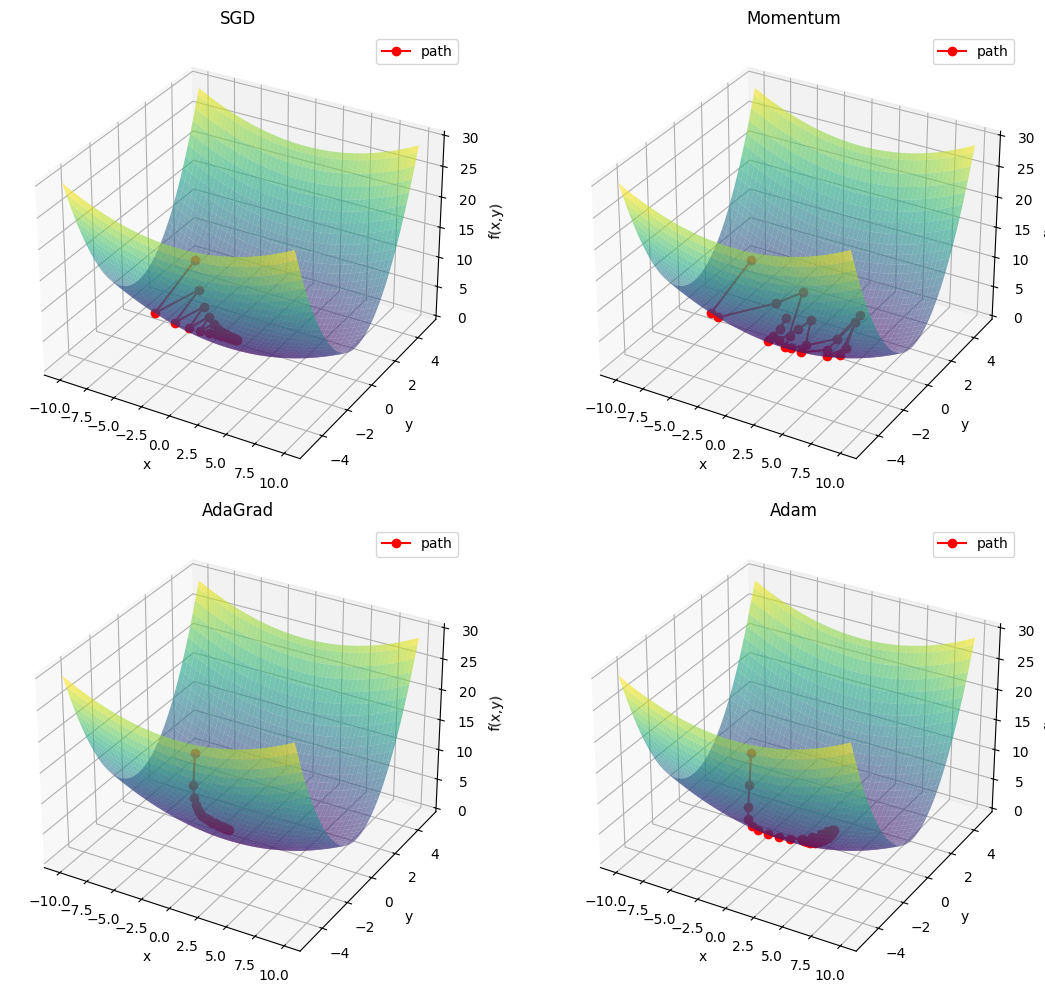

In [18]:
fig = plt.figure(figsize=(12, 10))
idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history, y_history = [], []
    params['x'], params['y'] = init_pos

    for i in range(25):
        x_history.append(params['x'])
        y_history.append(params['y'])
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.1)
    y = np.arange(-5, 5, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    ax = fig.add_subplot(2, 2, idx, projection='3d')
    idx += 1
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.6)
    ax.plot(x_history, y_history, f(np.array(x_history), np.array(y_history)), 'o-', color='red', label='path')

    ax.set_title(key)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")
    ax.legend()

plt.tight_layout()
plt.show()


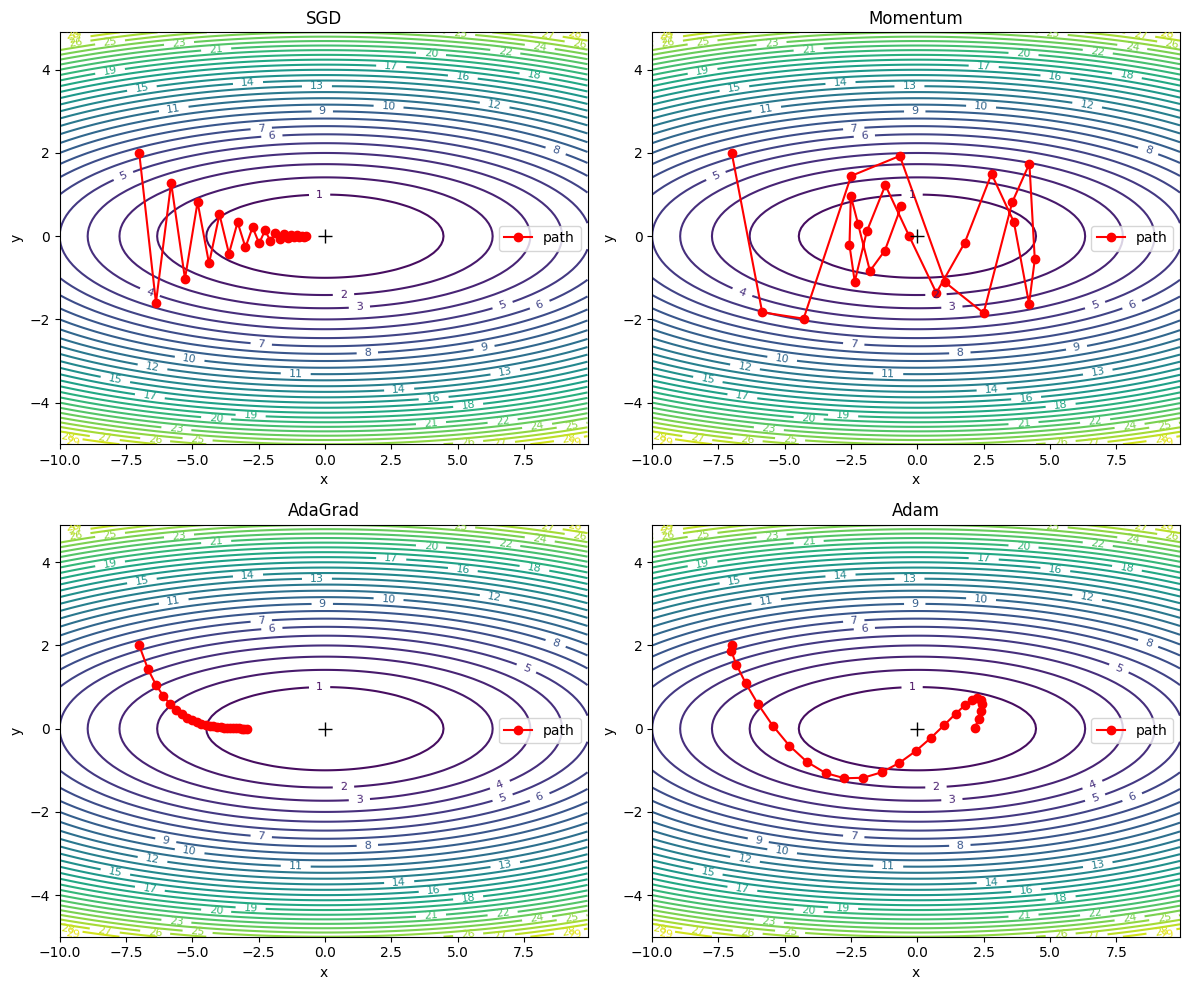

In [19]:
fig = plt.figure(figsize=(12, 10))
idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history, y_history = [], []
    params['x'], params['y'] = init_pos

    for i in range(25):
        x_history.append(params['x'])
        y_history.append(params['y'])
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.1)
    y = np.arange(-5, 5, 0.1)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    ax = fig.add_subplot(2, 2, idx)
    idx += 1
    contour = ax.contour(X, Y, Z, levels=30, cmap='viridis')
    ax.clabel(contour, inline=True, fontsize=8)

    ax.plot(x_history, y_history, 'o-', color='red', label='path')
    ax.plot(0, 0, '+', color='black', markersize=10)

    ax.set_title(key)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()

plt.tight_layout()
plt.show()
